The basic idea is to find out which categories of genomic regions (exons, promoters, enhancers, etc) contribute the most to the Nea. ancestry observed in present day Europeans. For example: have coding regions or enhancers been the main drivers of selection against Nea. introgression?

Links:

* info about different coordinate types: https://groups.google.com/forum/#!msg/biomart-users/OtQbAx3y9CA/wrF19ID1AgAJ
* https://www.biostars.org/p/2005/
* http://www.bioconductor.org/packages/release/bioc/vignettes/biomaRt/inst/doc/biomaRt.html#attribute-pages
* http://www.ensembl.org/info/data/biomart/biomart_r_package.html
* http://www.ensembl.info/blog/2015/06/01/biomart-or-how-to-access-the-ensembl-data-from-r/
* for checking with manually downloaded data: http://www.ensembl.org/info/data/biomart/how_to_use_biomart.html

Following [this](http://www.ensembl.org/info/data/biomart/biomart_r_package.html) tutorial, I want to extract coordinates of exonic and regulatory regions from the Ensembl database and then calculate the density of such regions in a defined window around each SNP.

These densities will they be used as predictors in a linear model, predicting the Nea. ancestry at each site.

Alternatively, I could just test if the distribution of densities for different regions differ based on frequency of Nea. alleles at each site.

In [96]:
library(tidyverse)
library(stringr)
library(magrittr)
library(parallel)

In [11]:
library(biomaRt)
library(rtracklayer)
library(BSgenome.Hsapiens.UCSC.hg19)

## Get coordinates of admixture array sites

In [15]:
source("../R/utils.R")

In [48]:
european_ids <- get_european_ids("../raw_data/10_24_2014_SGDP_metainformation_update.txt")

europeans <-
    load_dataset("../clean_data/ice_age.tsv", "../clean_data/sgdp.tsv", "../clean_data/archaics.tsv") %>%
    dplyr::select(c("chrom", "pos", european_ids)) %>% 
    dplyr::mutate(chrom=paste0("chr", chrom), start=pos, end=pos)

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),
  Altai = col_integer(),
  Vindija = col_integer(),
  Denisovan = col_integer()
)
Joining, by = c

In [49]:
sites <- makeGRangesFromDataFrame(europeans)
seqinfo(sites) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

In [18]:
length(sites)

[1] 484016

In [50]:
head(sites)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames           ranges strand
         <Rle>        <IRanges>  <Rle>
  [1]     chr1 [847983, 847983]      *
  [2]     chr1 [853089, 853089]      *
  [3]     chr1 [853596, 853596]      *
  [4]     chr1 [854793, 854793]      *
  [5]     chr1 [867552, 867552]      *
  [6]     chr1 [871401, 871401]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

## Extracting data from biomart

In [12]:
listEnsembl(version="75")

biomart,version
ensembl,Ensembl Genes 75
snp,Ensembl Variation 75
regulation,Ensembl Regulation 75
vega,Vega 55
pride,PRIDE (EBI UK)


In [13]:
ensembl <- useEnsembl(biomart="ensembl", version=75)

Find the name of the _H. sapiens_ dataset:

In [14]:
listDatasets(ensembl) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_gene_ensembl,Homo sapiens genes (GRCh37.p13),GRCh37.p13


## Getting exon coordinates

Connect to the human gene Ensembl dataset:

In [19]:
genes <- useDataset(dataset="hsapiens_gene_ensembl", mart=ensembl)

Show all available attributes that can be pulled out of biomart:

In [20]:
listAttributes(genes) %>% filter(page=="structure")

name,description,page
ensembl_gene_id,Ensembl Gene ID,structure
ensembl_transcript_id,Ensembl Transcript ID,structure
ensembl_peptide_id,Ensembl Protein ID,structure
chromosome_name,Chromosome Name,structure
start_position,Gene Start (bp),structure
end_position,Gene End (bp),structure
transcript_start,Transcript Start (bp),structure
transcript_end,Transcript End (bp),structure
strand,Strand,structure
external_gene_id,Associated Gene Name,structure


Show the available filters for extracting protein coding genes from the given mart:

In [21]:
listFilters(genes) %>% filter(str_detect(name, "type"))

name,description
type,Type
with_exp_est_celltype,with Expression est cell type
with_exp_atlas_celltype,with GNF/Atlas cell type ID(s)
biotype,Type
phenotype_description,Phenotype description
event_type,Event Type
cell_type_term,Cell type
atlas_celltype,


The "biotype" filter is what we are interested in, specifically its "protein_coding" subset:

In [29]:
exons <-
    getBM((listAttributes(genes) %>% filter(page=="structure"))$name,    # get all attributes
          filters=c("chromosome_name", "biotype"),                       # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),                           # chromosomes 1:22 and "protein_coding"
          mart=genes) %>%
    dplyr::select(chromosome_name, exon_chrom_start, exon_chrom_end) %>% # take only exon coordinates
    setNames(c("chrom", "start", "end")) %>%                             # rename the columns to BED names
    mutate(chrom=paste0("chr", chrom)) %>%                               # convert chromosome IDs to USCS format
    makeGRangesFromDataFrame %>%                                         # convert to GRanges object
    reduce                                                               # merge overlapping exons

In [31]:
seqinfo(exons) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

How many exons did I get? What is the total length of the exonic sequence (in Mb) that we extracted?

Bioinformatic databases are a mess - are the numbers I got reasonable?

In [32]:
length(exons)
sum(width(exons)) / 1e6

[1] 186343

[1] 75.23586

## Calculate the overlap of each window with each annotation feature

Those black magic GRanges overlap tricks are from [here](https://support.bioconductor.org/p/56880/).

### Developing the code on a simple test example

Testing sites, testing windows and testing exons

In [78]:
# sites
(s <- GRanges(seqnames="chr1", ranges=IRanges(c(10, 16, 22, 100), width=1)))
seqinfo(s) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

# windows around sites
(w <- flank(s, 5, both=TRUE))
seqinfo(w) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

# regions of interest (like exons)
(r <- GRanges(seqnames="chr1", ranges=IRanges(start=c(7, 12, 16, 200), end=c(9, 13, 21, 220))))
seqinfo(r) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

GRanges object with 4 ranges and 0 metadata columns:
      seqnames     ranges strand
         <Rle>  <IRanges>  <Rle>
  [1]     chr1 [ 10,  10]      *
  [2]     chr1 [ 16,  16]      *
  [3]     chr1 [ 22,  22]      *
  [4]     chr1 [100, 100]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

GRanges object with 4 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1 [ 5,  14]      *
  [2]     chr1 [11,  20]      *
  [3]     chr1 [17,  26]      *
  [4]     chr1 [95, 104]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

GRanges object with 4 ranges and 0 metadata columns:
      seqnames     ranges strand
         <Rle>  <IRanges>  <Rle>
  [1]     chr1 [  7,   9]      *
  [2]     chr1 [ 12,  13]      *
  [3]     chr1 [ 16,  21]      *
  [4]     chr1 [200, 220]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

Calculate the # of overlapping bases for each window:

In [79]:
# get the hit table between windows and regions they overlap with
(hits <- findOverlaps(w, r))

Hits object with 5 hits and 0 metadata columns:
      queryHits subjectHits
      <integer>   <integer>
  [1]         1           1
  [2]         1           2
  [3]         2           2
  [4]         2           3
  [5]         3           3
  -------
  queryLength: 4 / subjectLength: 4

In [80]:
# get all overlapping regions (duplicates for regions
# overlapping several windows/sites)
(w_over <- pintersect(w[queryHits(hits)], r[subjectHits(hits)]))

GRanges object with 5 ranges and 1 metadata column:
      seqnames    ranges strand |       hit
         <Rle> <IRanges>  <Rle> | <logical>
  [1]     chr1  [ 7,  9]      * |      TRUE
  [2]     chr1  [12, 13]      * |      TRUE
  [3]     chr1  [12, 13]      * |      TRUE
  [4]     chr1  [16, 20]      * |      TRUE
  [5]     chr1  [17, 21]      * |      TRUE
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [81]:
# for each window count the number of overlapping bases in regions
# as an integer vector
(w_counts <- tapply(w_over, queryHits(hits), FUN=function(x) sum(width(x))))

1 2 3 
5 7 5

In [8]:
# add the column with % overlap to the original sites object
s$overlap <- 0
s$overlap[as.numeric(names(w_counts))] <- unname(w_counts) / WINDOW_SIZE
s

GRanges object with 4 ranges and 1 metadata column:
      seqnames     ranges strand |   overlap
         <Rle>  <IRanges>  <Rle> | <numeric>
  [1]     chr1 [ 10,  10]      * |       0.5
  [2]     chr1 [ 16,  16]      * |       0.7
  [3]     chr1 [ 22,  22]      * |       0.5
  [4]     chr1 [100, 100]      * |         0
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

The code seems to work, let's construct a function:

In [38]:
calc_window_overlaps <- function(sites, regions, window_size) {
    # construct windows around each site
    windows <- flank(sites, window_size, both=TRUE)
    seqinfo(windows) <- seqinfo(sites)

    # get the hit table between windows and regions they overlap with
    hits <- findOverlaps(windows, regions)

    # get the all overlapping regions (duplicates for regions
    # overlapping several windows/sites)
    w_over <- pintersect(windows[queryHits(hits)], regions[subjectHits(hits)])

    # for each window count the number of overlapping bases in regions
    # as an integer vector
    w_counts <- tapply(w_over, queryHits(hits), FUN=function(x) { sum(width(x)) })

    # add the column with % overlap to the original sites object
    sites$overlap <- 0 # by default zero overlap for each site
    sites$overlap[as.numeric(names(w_counts))] <- unname(w_counts) / window_size

    mcols
}

Test of this function on the toy dataset from above:

In [39]:
calc_window_overlaps(s, r, 5)

GRanges object with 4 ranges and 1 metadata column:
      seqnames     ranges strand |   overlap
         <Rle>  <IRanges>  <Rle> | <numeric>
  [1]     chr1 [ 10,  10]      * |         1
  [2]     chr1 [ 16,  16]      * |       1.4
  [3]     chr1 [ 22,  22]      * |         1
  [4]     chr1 [100, 100]      * |         0
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [147]:
WINDOW_SIZE <- 100000

exon_densities <-
    mclapply(paste0("chr", 1:22),
             function(chr) {
                 calc_window_overlaps(sites[seqnames(sites) == chr], exons, WINDOW_SIZE)
             }, mc.cores=22) %>%
    do.call(c, .)

In [74]:
summary(mcols(x)$overlap)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00709 0.07943 0.09700 0.15620 0.64220 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


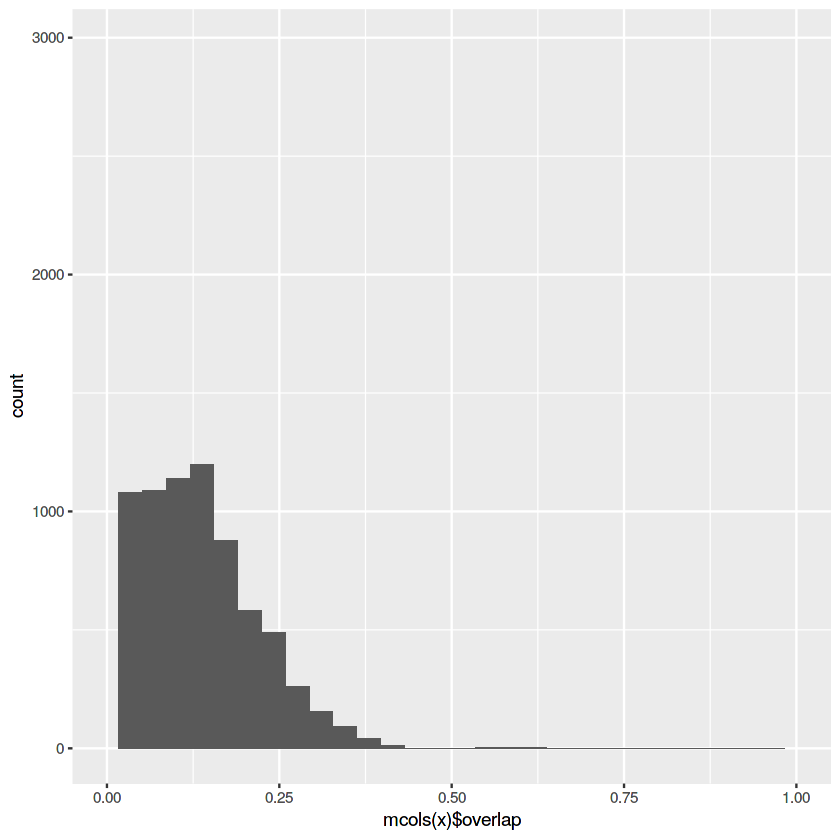

In [75]:
qplot(mcols(x)$overlap, xlim=c(0, 1))